In [1]:
import cv2
import glob
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
import numpy as np
import pickle

from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.core import debugger

In [2]:
FRESH = False
SAVE = False

In [25]:
# To save as normal python script (easier to git diff)
!jupyter nbconvert --to script pipeline.ipynb

[NbConvertApp] Converting notebook pipeline.ipynb to script
[NbConvertApp] Writing 28672 bytes to pipeline.py


In [4]:
# TESTING
test_image_paths = glob.glob('test_images/test*.jpg')
test_images = [cv2.imread(file) for file in test_image_paths]

In [5]:
# Camera Calibration
if FRESH:
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(9,6,0)
    cal_x = 9
    cal_y = 6
    objp = np.zeros((cal_x*cal_y,3), np.float32)
    objp[:,:2] = np.mgrid[0:cal_x, 0:cal_y].T.reshape(-1,2)

    # Prepare the object points and image points for the calibration
    calibration_image_paths = glob.glob('camera_cal/calibration*.jpg')
    calibration_images = [cv2.imread(file) for file in calibration_image_paths]
    calibration_images_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in calibration_images]

    obj_points = []
    img_points = []
    for gray in calibration_images_gray:
        ret, corners = cv2.findChessboardCorners(gray, (cal_x,cal_y), None)
        if ret:
            obj_points.append(objp)
            img_points.append(corners)

    img_size = (calibration_images_gray[0].shape[1],
                calibration_images_gray[0].shape[0])

    # Calibrate the camera (and save pickle)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
    calibration = {
        "ret": ret,
        "mtx": mtx,
        "dist": dist,
        "rvecs": rvecs,
        "tvecs": tvecs
    }
    pickle.dump(calibration, open("camera_cal/pickled_calibration.p", "wb"))
else:
    calibration = pickle.load(open("camera_cal/pickled_calibration.p", "rb"))

In [6]:
if FRESH:
    undistorted_images = [cv2.undistort(img, mtx, dist, None, mtx) for img in calibration_images_gray]
    f, axes = plt.subplots(len(calibration_images), 2, figsize=(10,60), sharey=True, sharex=True)

    for i, (org, undist) in enumerate(zip(calibration_images_gray, undistorted_images)):
        axes.flat[2*i].imshow(calibration_images_gray[i], cmap='gray')
        axes.flat[2*i + 1].imshow(undistorted_images[i], cmap='gray')

        if i == 0:
            axes.flat[i].set_title('Original Images')
            axes.flat[i+1].set_title('Undistorted Images')
            cv2.imwrite('output_images/original_chessboard.jpg', org)
            cv2.imwrite('output_images/undistorted_chessboard.jpg', undist)

    plt.tight_layout()

In [7]:
def region_of_interest(image, vertices):
    ysize = image.shape[0]
    xsize = image.shape[1]
    region_select = np.copy(image)
    region_select = np.zeros_like(image)

    imshape = image.shape
    left_bottom = (int(0.1 * imshape[1]), imshape[0])
    left_top = (int(0.45 * imshape[1]), int(0.5 * imshape[0]))
    right_top = (int(0.55 * imshape[1]), int(0.5 * imshape[0]))
    right_bottom = (int(0.9 * imshape[1]), int(imshape[0]))

    # Fit lines (y=Ax+B) to identify the  3 sided region of interest
    # np.polyfit() returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], left_top[0]), (left_bottom[1], left_top[1]), 1)
    fit_right = np.polyfit((right_bottom[0], right_top[0]), (right_bottom[1], right_top[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)
    fit_top = np.polyfit((left_top[0], right_top[0]), (left_top[1], right_top[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1])) & \
                        (YY > (XX*fit_top[0] + fit_top[1]))

    region_select[region_thresholds] = 1
    
    # Subtract region
    left_bottom = (int(0.2 * imshape[1]), imshape[0])
    left_top = (int(0.48 * imshape[1]), int(0.8 * imshape[0]))
    right_top = (int(0.52 * imshape[1]), int(0.8 * imshape[0]))
    right_bottom = (int(0.8 * imshape[1]), int(imshape[0]))

    # Fit lines (y=Ax+B) to identify the  3 sided region of interest
    # np.polyfit() returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], left_top[0]), (left_bottom[1], left_top[1]), 1)
    fit_right = np.polyfit((right_bottom[0], right_top[0]), (right_bottom[1], right_top[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)
    fit_top = np.polyfit((left_top[0], right_top[0]), (left_top[1], right_top[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1])) & \
                        (YY > (XX*fit_top[0] + fit_top[1]))
    
    region_select[region_thresholds] = 0
    return region_select

In [8]:
# Thresholding functions
PLOT = False

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise ValueError('Unrecognised orient {}'.format(orient))

    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    grad_binary = ((scaled >= thresh[0]) & (scaled <= thresh[1])).astype(int)

    if PLOT:
        plt.figure()
        plt.imshow(grad_binary, cmap='gray')
        plt.title('Abs Sobel Threshold ' + orient)
    return grad_binary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobel_xy_abs = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled = np.uint8(255 * sobel_xy_abs / np.max(sobel_xy_abs))

    mag_binary = ((scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])).astype(int)

    if PLOT:
        plt.figure()
        plt.imshow(mag_binary, cmap='gray')
        plt.title('Abs Magnitude Threshold')

    return mag_binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    grad = np.arctan2(sobely_abs, sobelx_abs)

    dir_binary = ((grad >= thresh[0]) & (grad <= thresh[1]))
    if PLOT:
        plt.figure()
        plt.imshow(dir_binary, cmap='gray')
        plt.title('Direction Threshold')
    return dir_binary


def lightness_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    binary_output = (hls[:,:,1] > thresh[0]) & (hls[:,:,1] <= thresh[1])
    if PLOT:
        plt.figure()
        plt.imshow(binary_output, cmap='gray')
        plt.title('Lightness Threshold')
    return binary_output


def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    binary_output = (hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])
    if PLOT:
        plt.figure()
        plt.imshow(binary_output, cmap='gray')
        plt.title('Saturation Threshold')
    return binary_output

In [9]:
# Constants for actual use of above functions
# Choose a Sobel kernel size
KSIZE = 3 # Choose a larger odd number to smooth gradient measurements

# Function which combines above threshold methods
def threshold_combination(img, plot=False):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=KSIZE, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=KSIZE, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=KSIZE, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
    saturation_binary = hls_select(img, thresh=(180, 255))
    lightness_binary = lightness_select(img, thresh=(230, 255))

    # combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined = (gradx & grady | mag_binary & dir_binary | saturation_binary | lightness_binary)
    combined = (gradx | saturation_binary | lightness_binary)
    
    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(combined, cmap='gray')
        ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

    return combined

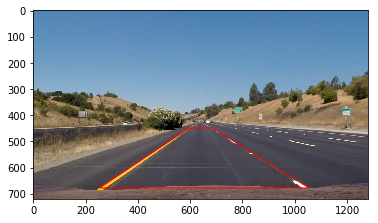

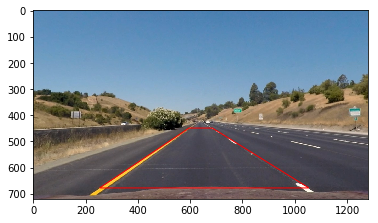

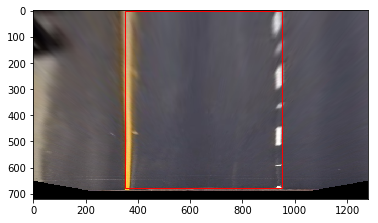

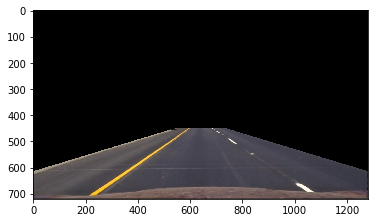

In [10]:
straight = cv2.imread('test_images/straight_lines1.jpg')
img_size = (straight.shape[1], straight.shape[0])
straight = cv2.cvtColor(straight, cv2.COLOR_BGR2RGB)

# SRC points determined from manual inspection of straight line image
src_points = np.float32([
    [596, 449], # top-left
    [685, 449], # top-right
    [1054, 678], # bottom-right
    [254, 678] # bottom-left
])
destination_points = np.float32([
    [350, 0], # top-left
    [950, 0], # top-right
    [950, 678], # bottom-right
    [350, 678] # bottom-left
])

plt.imshow(straight)
plt.gca().add_patch(Polygon(src_points, linewidth=1,edgecolor='r',facecolor='none'))

# Calculate the perspective transform matrix M
M = cv2.getPerspectiveTransform(src_points, destination_points)
# Get the inverse perspective transform
M_inv = cv2.getPerspectiveTransform(destination_points, src_points)

straight_undist = cv2.undistort(straight, calibration['mtx'], calibration['dist'], None, calibration['mtx'])
plt.figure()
plt.imshow(straight_undist)
plt.gca().add_patch(Polygon(src_points, linewidth=1,edgecolor='r',facecolor='none'))
straight_warped = cv2.warpPerspective(straight_undist, M, img_size, flags=cv2.INTER_LINEAR)
if SAVE:
    fig = plt.gcf()
    fig.savefig('output_images/src_points.jpg')

plt.figure()
plt.imshow(straight_warped)
plt.gca().add_patch(Polygon(destination_points, linewidth=1,edgecolor='r',facecolor='none'))
if SAVE:
    fig = plt.gcf()
    fig.savefig('output_images/dst_points.jpg')

straight_unwarped = cv2.warpPerspective(straight_warped, M_inv, img_size, flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(straight_unwarped)
if SAVE:
    fig = plt.gcf()
    fig.savefig('output_images/transform_unwarped.jpg')

In [11]:
# Windows (2 methods)
MIN_PIXELS = 50

n_windows = 9
W_WIDTH = 140
w_height = 90
margin = 80


def get_start_points_using_histogram(binary_img):
    img_height, img_width = binary_img.shape

    histogram = np.sum(binary_img[int(2*img_height/3):, :], axis=0)
    if PLOT:
        plt.figure()
        plt.plot(histogram)
        plt.title('Histogram')
        if SAVE:
            fig = plt.gcf()
            fig.savefig('output_images/histogram.jpg')

    # Get the start points for the windows (e.g. bottom of lane lines)
    midpoint = int(img_width / 2)
    left_start = np.argmax(histogram[:midpoint])
    right_start = midpoint + np.argmax(histogram[midpoint:])
    return left_start, right_start


# Function which finds indices of lane (will call twice e.g. for left/right)
def find_lane_indices_from_windows(binary_img, start_x, nonzero_x, nonzero_y):
    img_shape = binary_img.shape
    w_centre = start_x
    pixels = []
    window_history = []

    for n in range(n_windows):
        w_bottom = img_shape[0] - n*w_height
        w_top = w_bottom - w_height

        # Identify non-zero pixels within the window
        nonzero_pixels = (
            (nonzero_y >= w_top) & 
            (nonzero_y < w_bottom) & 
            (nonzero_x >= w_centre - W_WIDTH / 2) & 
            (nonzero_x < w_centre + W_WIDTH / 2)
        ).nonzero()[0]
        
        pixels.append(nonzero_pixels)
        
        # If sufficient non-zero pixels are found then renceter next window
        # on the mean position of the non-zero pixels
        if len(nonzero_pixels)>= MIN_PIXELS:
            w_centre = np.int(np.mean(nonzero_x[nonzero_pixels]))
    
    return np.concatenate(pixels)


def find_lane_indices_from_fit(fit, nonzero_x, nonzero_y):
    # Identify the x and y positions of all nonzero pixels in the image
    line = fit[0]*(nonzero_y**2) + fit[1]*nonzero_y + fit[2]
    lane_inds = ((nonzero_x > (line - margin)) & 
                 (nonzero_x < (line + margin)))
    return lane_inds


def get_fit_points(binary_img, left_fit, right_fit):
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx


def get_line_fits(binary_img, prev_left_fit=None, prev_right_fit=None):
    """
    If we have the previous line information (e.g. from previous frame in video):
        Use this to find the pixels which make up the new line.
    Else:
        Use the histogram to find the base of the lines and the window method
        to find the rest of the line

    Return the best fit through the pixels
    """
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    
    # NOTE - not using previously found lane as this seems to give worse results
#     if prev_left_fit is None or prev_right_fit is None:
    left_start, right_start = get_start_points_using_histogram(binary_img)
    
#     left_lane_inds = []
#     if prev_left_fit is not None:
#         left_lane_inds = find_lane_indices_from_fit(prev_left_fit, nonzero_x, nonzero_y)
#     if sum(left_lane_inds) <= MIN_PIXELS:
    left_lane_inds = find_lane_indices_from_windows(binary_img, left_start, nonzero_x, nonzero_y)        
    
#     right_lane_inds = []
#     if prev_right_fit is not None:
#         right_lane_inds = find_lane_indices_from_fit(prev_right_fit, nonzero_x, nonzero_y)        
#     if sum(right_lane_inds) <= MIN_PIXELS:
    right_lane_inds = find_lane_indices_from_windows(binary_img, right_start, nonzero_x, nonzero_y)


    # Extract left and right line pixel positions
    leftx = nonzero_x[left_lane_inds]
    lefty = nonzero_y[left_lane_inds]
    rightx = nonzero_x[right_lane_inds]
    righty = nonzero_y[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty, left_fitx, right_fitx = get_fit_points(binary_img, left_fit, right_fit)
    if PLOT:
        out_img = np.dstack((binary_img, binary_img, binary_img))*255
        out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0] # red
        out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255] # blue
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.title('Lane Lines')
        
        if SAVE:
            fig = plt.gcf()
            fig.savefig('output_images/Lane_Lines.jpg')

    return left_fit, right_fit

In [12]:
# Define conversions in x and y from pixels space to meters
# TODO - check these from the test images
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fixed values taked from the max diffs in the first 20s of the video (when the lane lines are found well)
# plus a 10% tolerance
# MAX_LEFT_RIGHT_DIFF = np.asarray([  2.44376727e-04, 3.05918424e-01, 6.54290211e+02]) * 1.1
MAX_FRAME_DIFF = np.asarray([  1.54392272e-04, 1.79490520e-01, 6.14956242e+01]) * 1.1

MAX_LEFT_RIGHT_DIFF = np.asarray([0.0004, 0.8, 1000])
# MAX_FRAME_DIFF = np.asarray([  1.54392272e-04, 1.79490520e-01, 6.14956242e+01]) * 1.1

def convert_fit_to_metres(fit, mx, my):
    # Convert the fit from pixels to metres
    new_fit = (
        mx / (my**2) * fit[0],
        mx / my * fit[1],
        fit[0]
    )
    return new_fit

    
def calculate_curvature(fit, y0):
    """
    For f(y) = Ay^2 + By + c
    R = (1 + (2Ay+B)^2)^(3/2) / abs(2A)
    """
    return (1 + (2*fit[0]*y0 + fit[1])**2)**(3/2) / np.abs(2*fit[0])

def get_curvatures(fits):
    fits_m = [convert_fit_to_metres(fit, xm_per_pix, ym_per_pix) for fit in fits]
    return [calculate_curvature(fit, test.shape[0]) for fit in fits_m]

def get_curvature(fit):
    fit_m = convert_fit_to_metres(fit, xm_per_pix, ym_per_pix)
    return calculate_curvature(fit_m, test.shape[0])

def get_offset(img, fits):
    y0, w = img.shape
    lane_line_bases = [fit[0]*y0**2 + fit[1]*y0 + fit[2] for fit in fits]
    return (np.mean(lane_line_bases) - w/2) * xm_per_pix

def sanity_check_fits(left_fit, right_fit):
    """
    For f(y) = Ay^2 + By + C
    """
    fit_diff = left_fit - right_fit
    return not np.less(MAX_LEFT_RIGHT_DIFF, np.abs(fit_diff)).any()

In [13]:
def colour_lane(warped_binary, left_fit, right_fit, col=(0,255, 0)):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    lane_coloured_img = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty, left_fitx, right_fitx = get_fit_points(warped_binary, left_fit, right_fit)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right)).astype(np.int32)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(lane_coloured_img, [pts], col)
    return lane_coloured_img

In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  

        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  

        #radius of curvature of the line in some units
        self.curvature = None

        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
    
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

# Use this to have a left/right Line and can have the functions comparing them here?
class Frame():
    def __init__(self):

        self.original_img = None

        self.left_line = None
        self.right_line = None

        self.offset = None

        self.result_img = None
    
    @property
    def fit_diff(self):
        return np.abs(self.left_line.current_fit - self.right_line.current_fit)


class Clip():
    def __init__(self):
        self.frames = deque([], maxlen=10)
    
    @property
    def previous_frame(self):
        return self.frames[-1]
    
    @property
    def previous_fits(self):
        try:
            prev_left_fit = self.previous_frame.left_line.current_fit
            prev_right_fit = self.previous_frame.right_line.current_fit
        except IndexError:
            prev_left_fit = None
            prev_right_fit = None
        return prev_left_fit, prev_right_fit
    
    def calculate_next_fits(self):
        # Get most recent 5 calculated frames from previous 10 frames
        left_fits = deque([], maxlen=5)
        right_fits = deque([], maxlen=5)
        for f in self.frames:
            if frame.left_line.detected:
                left_fits.append(f.left_line.current_fit)
            if frame.right_line.detected:
                right_fits.append(f.right_line.current_fit)

        # Calculate the next fit as the average of the previous fits
        return np.mean(np.asarray(left_fits), axis=0), np.mean(np.asarray(right_fits), axis=0)


In [15]:
def list_to_sig_figs(arr, n=1):
    rounded = []
    for x in arr:
        if x == 0:
            rounded.append(0)
        rounded.append(str(round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))))
    return rounded

In [16]:
def add_info_to_image(frame):
    info = [
        'Left Curvature (m) ' + str(round(frame.left_line.curvature)),
        'Right Curvature (m) ' + str(round(frame.right_line.curvature)),
        'Offset (m) ' + str(round(frame.offset, 2)),
        'Left fit (m) ' + str(list_to_sig_figs(frame.left_line.current_fit, 2)),
        'Right fit (m) ' + str(list_to_sig_figs(frame.right_line.current_fit, 2)),
        'Diff ' + str(list_to_sig_figs(np.abs(frame.left_line.current_fit - frame.right_line.current_fit), 2))
    ]

    font = cv2.FONT_HERSHEY_SIMPLEX    
    for i, line in enumerate(info):
#         plt.text(50, 50*(i+1), line, color='white', bbox={'facecolor':'black', 'alpha':0.4, 'pad':5})
        cv2.putText(frame.result, line ,(50, 50*(i+1)), font, 1, (255,255,255), 2, cv2.LINE_AA)

In [17]:
# 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
# DONE
# 2. Apply a distortion correction to raw images.
# DONE
# 3. Use color transforms, gradients, etc., to create a thresholded binary image.
# IMPLEMENTED BUT NOT FINISHED
# 4. Apply a perspective transform to rectify binary image ("birds-eye view").
# DONE
# 5. Detect lane pixels and fit to find the lane boundary.
# DONE HISTOGRAM METHOD BUT NOT CONVOLUTION. (and not visualisation, and only for 1 frame)
# 6. Determine the curvature of the lane and vehicle position with respect to center.
# DONE CURVATURE BUT NOT POSITION (POSITION PROBABLY WRONG ATM)
# 7. Warp the detected lane boundaries back onto the original image.
# DONE
# 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
# DONE

def pipeline(img, calibration, M, clip, plot=False):
    # Save the results between frames    
    frame = Frame()
    frame.left_line = Line()
    frame.right_line = Line()
    
    # ---- Undistort image ----
    img_undist = cv2.undistort(img, calibration['mtx'], calibration['dist'], None, calibration['mtx'])
    
    # ---- Threshold to find relevant pixels ----
    threshold_binary = threshold_combination(img_undist, False)
    
    # ---- Mask image to select region of interest ----
    imshape = threshold_binary.shape
    vertices = np.array([[(int(0.1 * imshape[1]), imshape[0]),
                        (int(0.47 * imshape[1]), int(0.6 * imshape[0])),
                        (int(0.53 * imshape[1]), int(0.6 * imshape[0])),
                        (int(imshape[1]), int(imshape[0]))]],
                      dtype=np.int32)
    mask = region_of_interest(threshold_binary, vertices)
    img_masked = (threshold_binary & mask)
    
    # ---- Warp image to view from above ----
    warped_binary = cv2.warpPerspective(np.uint8(img_masked), M, img_size, flags=cv2.INTER_LINEAR)
    
    # ---- Find the lines  ----
    prev_left_fit, prev_right_fit = clip.previous_fits
    left_fit, right_fit = get_line_fits(warped_binary, prev_left_fit, prev_right_fit)
    
    lr_match = sanity_check_fits(left_fit, right_fit)
    
    if lr_match:
        frame.left_line.detected = True
        frame.right_line.detected = True
    else:
        frame.left_line.detected = False
        frame.right_line.detected = False
        left_fit, right_fit = clip.calculate_next_fits()

    frame.left_line.current_fit = left_fit
    frame.right_line.current_fit = right_fit
    
    # ---- Get the curvature and the offset from the car to the lane centre ----
    frame.left_line.curvature, frame.right_line.curvature = get_curvatures([left_fit, right_fit])
    frame.offset = get_offset(warped_binary, [left_fit, right_fit])

    # ---- Fill in the lane in the warped image---- 
#     if lr_match:
    lane_coloured_img = colour_lane(warped_binary, left_fit, right_fit, (0, 255, 0))
#     else:
#         lane_coloured_img = colour_lane(warped_binary, left_fit, right_fit, (255, 0, 0))

    # ---- Warp the blank back to original image space using inverse perspective matrix (Minv) ----
    new_warp = cv2.warpPerspective(lane_coloured_img, M_inv, (warped_binary.shape[1], warped_binary.shape[0]), flags=cv2.INTER_LINEAR)

    # ---- Combine the result with the original image ----
    result = cv2.addWeighted(img_undist, 1, new_warp, 0.3, 0)

    # TODO - add coloured detected pixels to final image

    frame.result = result    
    
    # ---- Add information to final image ----
    add_info_to_image(frame)

    if plot:
        images = [
            (img, 'Original'),
            (img_undist, 'Undistorted'),
            (threshold_binary, 'Threshold (combined)'),
            (mask, 'Mask'),
            (img_masked, 'Masked'),
            (warped_binary, 'Warped Threshold'),
            (lane_coloured_img, 'Lane filled'),
            (new_warp, 'Lane unwarped'),
            (result, 'Result'),
        ]

        for i, title in images:
            plt.figure()
            plt.imshow(i, cmap='gray')
            plt.title(title)
            if SAVE:
                fig = plt.gcf()
                fig.savefig('output_images/' + "_".join(t for t in title.split(" ")) + '.jpg')

    return frame

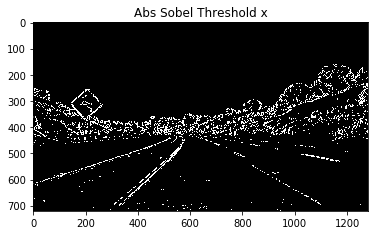

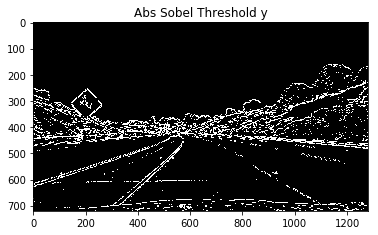

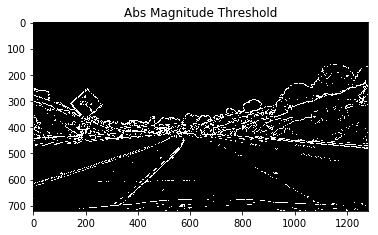

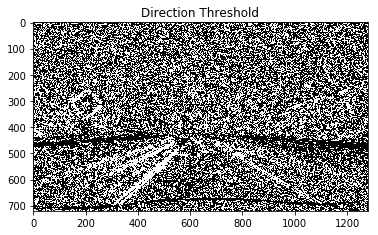

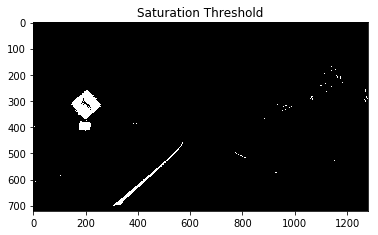

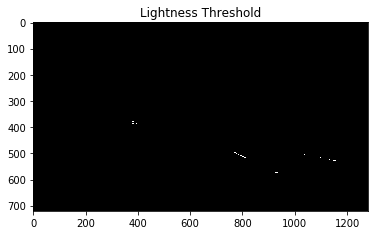

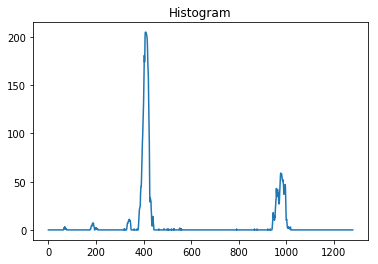

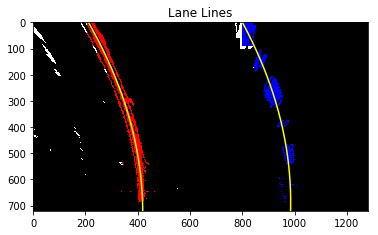

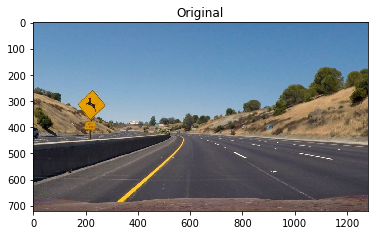

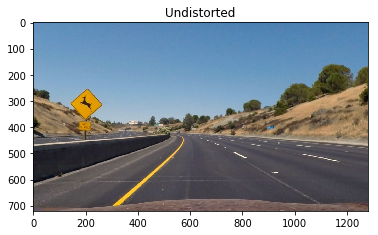

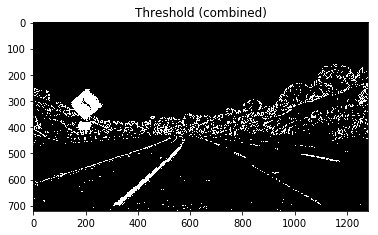

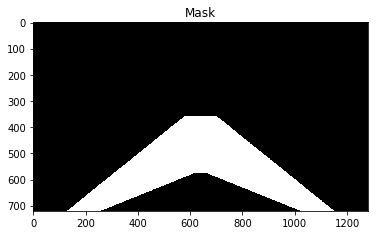

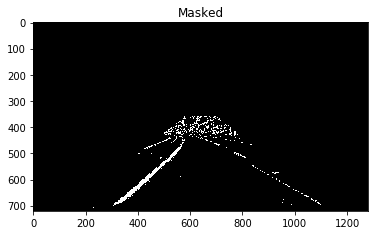

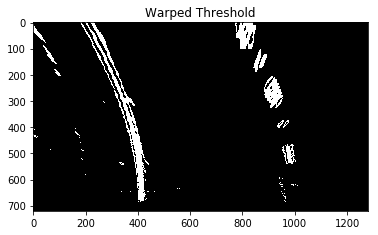

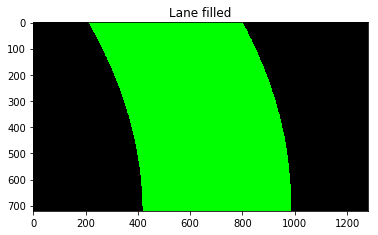

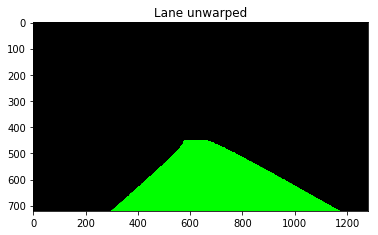

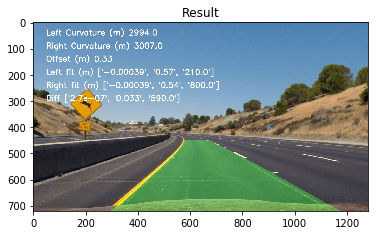

In [18]:
PLOT = True
SAVE = True
test = test_images[1]
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
frame = pipeline(test, calibration, M, Clip(), plot=True)
SAVE = False

In [19]:
# Useful to remember
# threshold_binary_2 = threshold_binary[:,:,None]
# threshold_3 = np.dstack((np.zeros_like(threshold_binary), np.zeros_like(threshold_binary), threshold_binary)) * 255

In [20]:
PLOT = False
clip = Clip()
def process_image(img):
    frame = pipeline(img, calibration, M, clip, plot=False)
    clip.frames.append(frame)
    return frame.result

# Videos
output_file = 'output_images/video_out.mp4'
video2_output = 'output_images/harder_challenge_video_out.mp4'

tricky1 = VideoFileClip("project_video.mp4").subclip(21,24)
tricky2 = VideoFileClip("project_video.mp4").subclip(38,42)
easy = VideoFileClip("project_video.mp4").subclip(0,2)
project_video = VideoFileClip("project_video.mp4")
video = project_video

In [21]:
video_out = video.fl_image(process_image) #NOTE: this function expects color images!!
%time video_out.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video output_images/video_out.mp4
[MoviePy] Writing video output_images/video_out.mp4


100%|█████████▉| 1260/1261 [08:20<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_out.mp4 

CPU times: user 7min 40s, sys: 1min 38s, total: 9min 18s
Wall time: 8min 22s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

In [23]:
# Calculate max diffs between lines to use as sanity check

fit_diffs = np.asarray([np.abs(frame.left_line.current_fit - frame.right_line.current_fit) for frame in clip.frames])
# fit_diffs = np.asarray([frame.fit_diff for frame in clip.frames])
print(fit_diffs.shape)
max_line_diffs = np.amax(fit_diffs, 0)
print(max_line_diffs)

# Get the max diffs between frames from the clip
fit_diffs = []
for i in range(len(clip.frames)):
    if i == 0:
        continue
    left_fit_diffs = np.abs(clip.frames[i].left_line.current_fit - clip.frames[i-1].left_line.current_fit)
    right_fit_diffs = np.abs(clip.frames[i].right_line.current_fit - clip.frames[i-1].right_line.current_fit)
    fit_diffs.extend([left_fit_diffs, right_fit_diffs])

fit_diffs = np.asarray(fit_diffs)
max_frame_diffs = np.amax(fit_diffs, 0)

(10, 3)
[  1.59114881e-04   1.58864697e-01   6.41291319e+02]


In [ ]:
video1 = VideoFileClip("challenge_video.mp4")
video_out = video1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_out.write_videofile('output_images/challenge_video_out.mp4', audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_images/challenge_video_out.mp4'))

[MoviePy] >>>> Building video output_images/challenge_video_out.mp4
[MoviePy] Writing video output_images/challenge_video_out.mp4


 93%|█████████▎| 452/485 [07:34<00:31,  1.04it/s]

In [ ]:
video2 = VideoFileClip("harder_challenge_video.mp4")
video_out = video1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_out.write_videofile('output_images/harder_challenge_video_out.mp4', audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_images/harder_challenge_video_out.mp4'))